The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.5


# The Dataset for Pretraining Word Embedding
:label:`sec_word2vec_data`

In this section, we will introduce how to preprocess a dataset with
negative sampling :numref:`sec_approx_train` and load into minibatches for
word2vec training. The dataset we use is [Penn Tree Bank (PTB)]( https://catalog.ldc.upenn.edu/LDC99T42), which is a small but commonly-used corpus. It takes samples from Wall Street Journal articles and includes training sets, validation sets, and test sets.

First, import the packages and modules required for the experiment.


In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l

## Reading and Preprocessing the Dataset

This dataset has already been preprocessed. Each line of the dataset acts as a sentence. All the words in a sentence are separated by spaces. In the word embedding task, each word is a token.


In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

Next we build a vocabulary with words appeared not greater than 10 times mapped into a "&lt;unk&gt;" token. Note that the preprocessed PTB data also contains "&lt;unk&gt;" tokens presenting rare words.


In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## Subsampling

In text data, there are generally some words that appear at high frequencies, such "the", "a", and "in" in English. Generally speaking, in a context window, it is better to train the word embedding model when a word (such as "chip") and a lower-frequency word (such as "microprocessor") appear at the same time, rather than when a word appears with a higher-frequency word (such as "the"). Therefore, when training the word embedding model, we can perform subsampling on the words :cite:`Mikolov.Sutskever.Chen.ea.2013`. Specifically, each indexed word $w_i$ in the dataset will drop out at a certain probability. The dropout probability is given as:

$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

Here, $f(w_i)$ is the ratio of the instances of word $w_i$ to the total number of words in the dataset, and the constant $t$ is a hyperparameter (set to $10^{-4}$ in this experiment). As we can see, it is only possible to drop out the word $w_i$ in subsampling when $f(w_i) > t$. The higher the word's frequency, the higher its dropout probability.


In [4]:
#@save
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
    # Count the frequency for each word
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return (random.uniform(0, 1) < math.sqrt(
            1e-4 / counter[token] * num_tokens))

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]

subsampled = subsampling(sentences, vocab)

Compare the sequence lengths before and after sampling, we can see subsampling significantly reduced the sequence length.


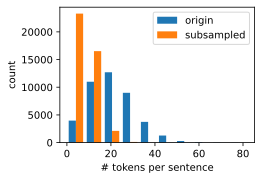

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]])
d2l.plt.xlabel('# tokens per sentence')
d2l.plt.ylabel('count')
d2l.plt.legend(['origin', 'subsampled']);

For individual tokens, the sampling rate of the high-frequency word "the" is less than 1/20.


In [6]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([line.count(token) for line in sentences])}, '
            f'after={sum([line.count(token) for line in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2116'

But the low-frequency word "join" is completely preserved.


In [7]:
compare_counts('join')

'# of "join": before=45, after=45'

Last, we map each token into an index to construct the corpus.


In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[0, 0], [71, 2115, 274, 406], [12, 140, 5277, 3054, 1580, 95]]

## Loading the Dataset

Next we read the corpus with token indicies into data batches for training.

### Extracting Central Target Words and Context Words

We use words with a distance from the central target word not exceeding the context window size as the context words of the given center target word. The following definition function extracts all the central target words and their context words. It uniformly and randomly samples an integer to be used as the context window size between integer 1 and the `max_window_size` (maximum context window).


In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word
        # - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(
                range(max(0, i - window_size),
                      min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Next, we create an artificial dataset containing two sentences of 7 and 3 words, respectively. Assume the maximum context window is 2 and print all the central target words and their context words.


In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


We set the maximum context window size to 5. The following extracts all the central target words and their context words in the dataset.


In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 353034'

### Negative Sampling

We use negative sampling for approximate training. For a central and context word pair, we randomly sample $K$ noise words ($K=5$ in the experiment). According to the suggestion in the Word2vec paper, the noise word sampling probability $P(w)$ is the ratio of the word frequency of $w$ to the total word frequency raised to the power of 0.75 :cite:`Mikolov.Sutskever.Chen.ea.2013`.

We first define a class to draw a candidate according to the sampling weights. It caches a 10000 size random number bank instead of calling `random.choices` every time.


In [12]:
#@save
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population,
                                             self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 0, 1, 1, 1, 0, 2, 1, 1, 2]

In [13]:
#@save
def get_negatives(all_contexts, corpus, K):
    counter = d2l.count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

### Reading into Batches

We extract all central target words `all_centers`, and the context words `all_contexts` and noise words `all_negatives` of each central target word from the dataset. We will read them in random minibatches.

In a minibatch of data, the $i^\mathrm{th}$ example includes a central word and its corresponding $n_i$ context words and $m_i$ noise words. Since the context window size of each example may be different, the sum of context words and noise words, $n_i+m_i$, will be different. When constructing a minibatch, we concatenate the context words and noise words of each example, and add 0s for padding until the length of the concatenations are the same, that is, the length of all concatenations is $\max_i n_i+m_i$(`max_len`). In order to avoid the effect of padding on the loss function calculation, we construct the mask variable `masks`, each element of which corresponds to an element in the concatenation of context and noise words, `contexts_negatives`. When an element in the variable `contexts_negatives` is a padding, the element in the mask variable `masks` at the same position will be 0. Otherwise, it takes the value 1. In order to distinguish between positive and negative examples, we also need to distinguish the context words from the noise words in the `contexts_negatives` variable. Based on the construction of the mask variable, we only need to create a label variable `labels` with the same shape as the `contexts_negatives` variable and set the elements corresponding to context words (positive examples) to 1, and the rest to 0.

Next, we will implement the minibatch reading function `batchify`. Its minibatch input `data` is a list whose length is the batch size, each element of which contains central target words `center`, context words `context`, and noise words `negative`. The minibatch data returned by this function conforms to the format we need, for example, it includes the mask variable.


In [14]:
#@save
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape(
        (-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks),
            torch.tensor(labels))

Construct two simple examples:


In [15]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


We use the `batchify` function just defined to specify the minibatch reading method in the `DataLoader` instance.

## Putting All Things Together

Last, we define the `load_data_ptb` function that read the PTB dataset and return the data iterator.


In [16]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify,
                                            num_workers=num_workers)
    return data_iter, vocab

Let us print the first minibatch of the data iterator.


In [17]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


## Summary

* Subsampling attempts to minimize the impact of high-frequency words on the training of a word embedding model.
* We can pad examples of different lengths to create minibatches with examples of all the same length and use mask variables to distinguish between padding and non-padding elements, so that only non-padding elements participate in the calculation of the loss function.

## Exercises

1. We use the `batchify` function to specify the minibatch reading method in the `DataLoader` instance and print the shape of each variable in the first batch read. How should these shapes be calculated?


[Discussions](https://discuss.d2l.ai/t/1330)
